In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#to import cv2 on your local machine, first run pip install opencv-python
import cv2

In [74]:
base_url= 'D:/Grad_dip/4.Applied Data Analysis/Assessment/Assignment-2/Data/'
train_df = pd.read_csv(base_url + 'trainset_students.csv')
train_df.head()

ID     Label  Label_Confidence
0  818021711  Positive            0.6715
1  911806503  Positive            0.6642
2  882035319  Negative            0.6683
3  880892525   Neutral            0.3360
4  828003448  Positive            1.0000

# EDA

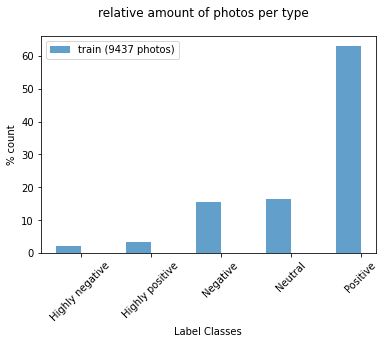

In [75]:
# let's see the label distribution
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('Label Classes')
    plt.ylabel(ylabel_text)

plt.suptitle('relative amount of photos per type')
plot_bar(train_df['Label'], loc='left')
plt.legend([
    'train ({0} photos)'.format(len(train_df['Label']))
]);

looks imbalanced right? you should know by now what that means! let's see some random images with their labels


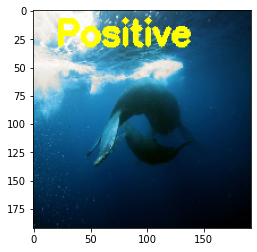

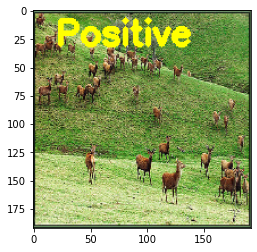

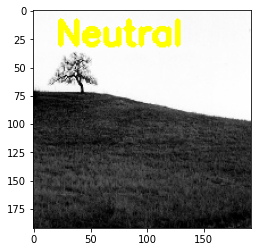

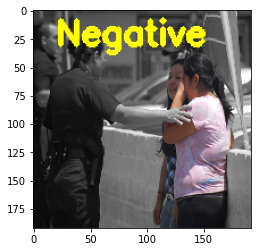

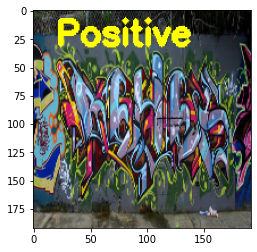

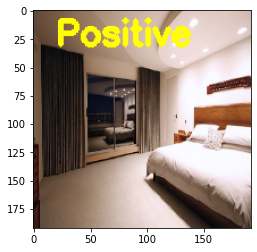

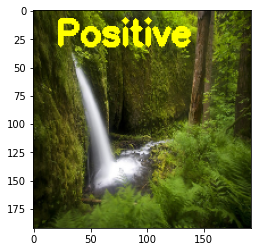

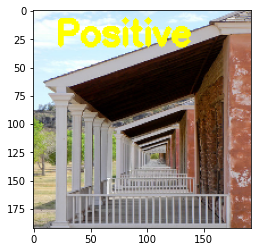

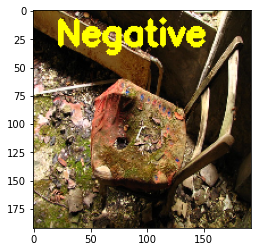

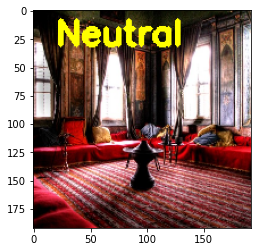

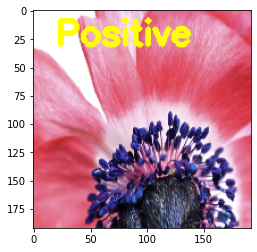

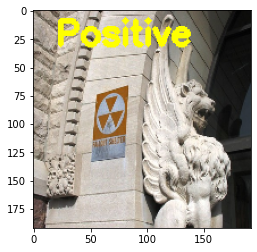

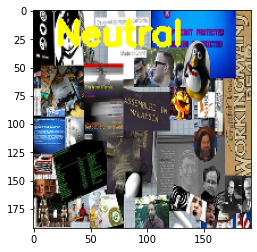

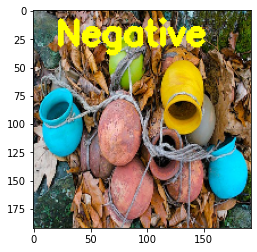

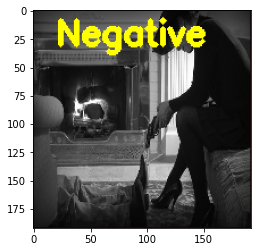

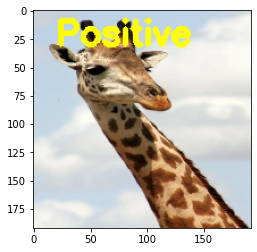

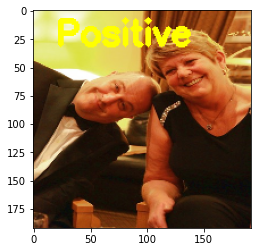

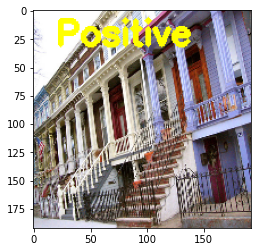

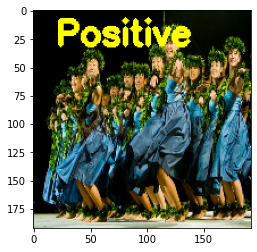

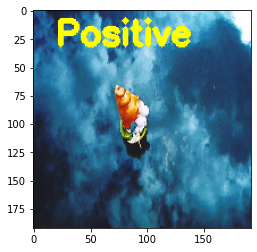

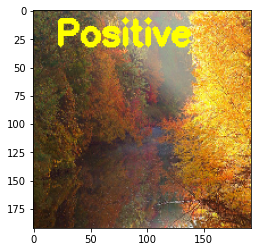

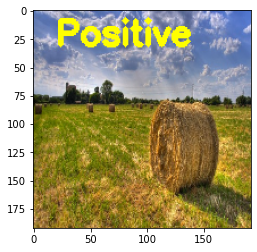

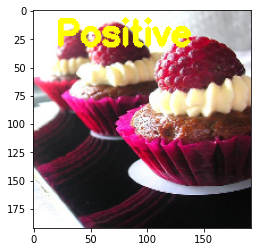

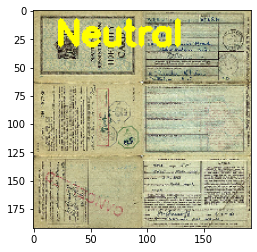

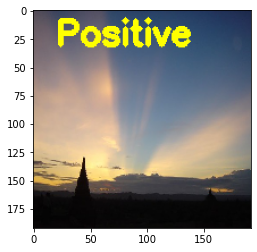

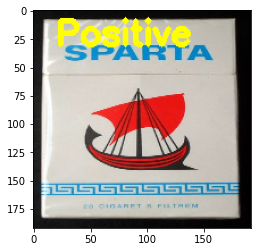

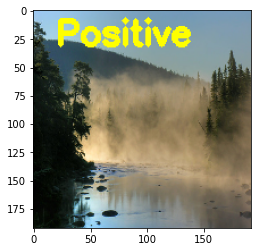

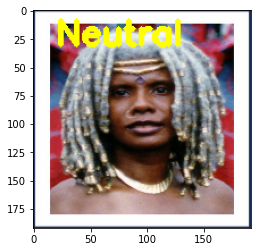

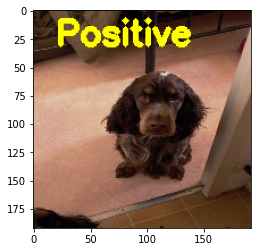

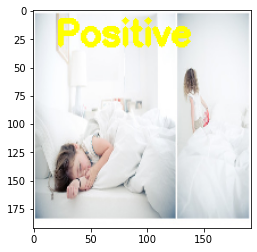

In [41]:
# show 30 random label on image
fixed_size = tuple((192, 192))
for i in np.random.randint(low=0, high = len(train_df), size=30):
    file = base_url + "images/" + str(train_df.iloc[i,0]) + ".jpg"
    
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)
    cv2.putText(image, train_df.iloc[i,1], (20,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)
    cv2.putText(image, str(train_df.iloc[i,2]), (320,30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0,255,255), 3)

    # display the output image
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Looks like positive images are very bright having widespread colour-combination. On the other hand,Negative images are in gray scale or black or red coloured. Neutral ones are mostly following a pattern.

In [ ]:
# Let's investigate the confidence level distribution for each class.

In [7]:
import plotly.express as px
df =train_df
fig = px.histogram(df, x="Label_Confidence", y="ID", color="Label", facet_col="Label")
fig.show()

We can hardly follow Label confidence distribution for highly positive and highly negative classes from the above facetted bar plot.
So, let's have a look individually only those two classes

(array([104.,   0.,  15.,  12.,  78.,  79.,   1.,   1.,   0.,  13.]),
 array([0.3338 , 0.40042, 0.46704, 0.53366, 0.60028, 0.6669 , 0.73352,
        0.80014, 0.86676, 0.93338, 1.     ]),
 <BarContainer object of 10 artists>)

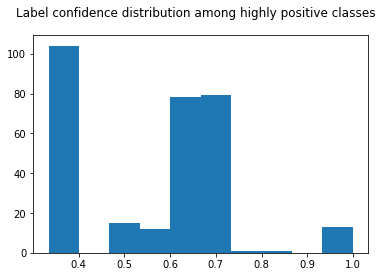

In [15]:
plt.suptitle('Label confidence distribution among highly positive classes')
plt.hist(train_df[train_df.Label=='Highly positive'].Label_Confidence)

(array([54.,  0., 14., 16., 47., 37.,  2.,  5.,  2., 11.]),
 array([0.3342 , 0.40078, 0.46736, 0.53394, 0.60052, 0.6671 , 0.73368,
        0.80026, 0.86684, 0.93342, 1.     ]),
 <BarContainer object of 10 artists>)

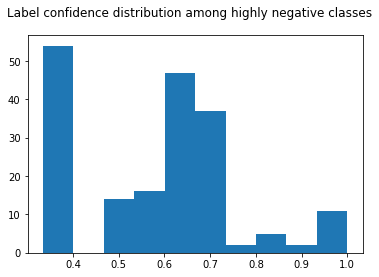

In [16]:
plt.suptitle('Label confidence distribution among highly negative classes')
plt.hist(train_df[train_df.Label=='Highly negative'].Label_Confidence)

In [17]:
train_df.iloc[i,2]

1.0

Some interesting observations right? I am not going to keep exploring but you probably should! Think about the color distributions in each class for example.

# Feature Extraction

Feature extraction is performed in two stages:

1) feature extrated from the provided features and 2) feature extracted from the pixels of the images

In [ ]:
#!pip install mahotas==1.4.11
#!pip install opencv-python

     |████████████████████████████████| 5.7 MB 8.2 MB/s 


In [76]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from skimage.io import imread, imshow
from skimage import filters
from skimage.filters import prewitt_h,prewitt_v
import mahotas

import cv2
import os

## feature extractors

In [78]:
# feature-descriptor-1: Hu Moments
# here is more info about this feature
# https://learnopencv.com/shape-matching-using-hu-moments-c-python/
def fd_hu_moments(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

# feature-descriptor-2: Haralick Texture
# here is more info about this feature
# https://www.nature.com/articles/s41598-017-04151-4

def fd_haralick(image):
    # convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(gray).mean(axis=0)
    # return the result
    return haralick

# feature-descriptor-3: Color Histogram
# here is more info about this feature
# https://en.wikipedia.org/wiki/Color_histogram
def fd_histogram(image, mask=None, bins = 8):
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()

def fd_pixel(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pixel= np.reshape(image,150*150)
    return pixel

## convert all images to numeric features

In [79]:
# to convert the input image to a fixed size of (500, 500).
# this can take a while on Colab beacuse of the I/O time (around 30 minutes, I stopped it after 20!)
fixed_size = tuple((500, 500))

# empty lists to hold feature vectors and labels
global_features = []
labels = []
confidence = []

# loop over the images
for row in train_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"

    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image, fixed_size)

    ####################################
    # Global Feature extraction
    ####################################
    fv_hu_moments = fd_hu_moments(image)
    fv_haralick   = fd_haralick(image)
    fv_histogram  = fd_histogram(image, bins = 8)

    ###################################
    # Concatenate global features
    ###################################
    global_feature = np.hstack([fv_histogram, fv_haralick, fv_hu_moments])
    # global_feature = np.hstack([fv_histogram, fv_hu_moments])

    # update the list of labels and feature vectors
    labels.append(row[1]['Label'])
    confidence.append(row[1]['Label_Confidence'])
    global_features.append(global_feature)

In [80]:
# to convert the input image to a fixed pixel size of (150, 150).

fixed_size = tuple((150, 150))

# empty lists to hold pixel vectors

pixel_feature_list =[]

# loop over the images
for row in train_df.iterrows():
    # get the image file name
    file = base_url + "images/"  + str(row[1]['ID']) + ".jpg"
    # read the image and resize it to a fixed-size
    image = cv2.imread(file)
    image = cv2.resize(image,fixed_size)
    fv_pixel       = fd_pixel(image)
    
    pixel_feature_list.append(fv_pixel)
    

## Preprocessing :  Reading data, feature normalization, label encoding:

In [81]:
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le = LabelEncoder()
target = le.fit_transform(labels)
print("[STATUS] training labels encoded...")

# scale features in the range (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)
rescaled_pixel = scaler.fit_transform(pixel_feature_list)
print("[STATUS] feature vector and pixel vector normalized...")

print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector size (9437, 532)
[STATUS] training Labels (9437,)
[STATUS] training labels encoded...
[STATUS] feature vector and pixel vector normalized...
[STATUS] target labels: [4 4 2 ... 4 0 4]
[STATUS] target labels shape: (9437,)


In [194]:
feature_data_train = pd.DataFrame(rescaled_features)
df_labels = pd.DataFrame(target)
df_labels.rename(columns = {0:'Label'}, inplace = True)
#pixel_feature = pd.DataFrame(rescaled_pixel)

In [191]:
feature_data_train.shape

(9437, 532)

In [192]:
# Taking cubic value of for confidence to wight the higher value
df_conf = pd.DataFrame(train_df['Label_Confidence']**3)

In [193]:
df = pd.concat([feature_data_train,df_conf], axis=1)
df.head()

0         1         2         3         4         5         6  \
0  0.776460  0.004142  0.025869  0.111169  0.113330  0.002086  0.000724   
1  0.007428  0.000803  0.014841  0.054755  0.162456  0.212114  0.262593   
2  0.009126  0.118956  0.161748  0.140321  0.292609  0.014038  0.067817   
3  0.000732  0.000000  0.000022  0.000034  0.000110  0.000286  0.000535   
4  0.037449  0.000329  0.000472  0.000426  0.000464  0.000242  0.000236   

          7         8         9  ...       523       524       525       526  \
0  0.009833  0.001737  0.004026  ...  0.452897  0.996127  0.114052  0.002887   
1  0.098472  0.000555  0.001591  ...  0.438290  0.998778  0.022461  0.000189   
2  0.053721  0.002986  0.023985  ...  0.632849  0.984479  0.042172  0.000072   
3  0.004058  0.000000  0.000030  ...  0.429705  0.997130  0.087192  0.000092   
4  0.003827  0.002299  0.003443  ...  0.736119  0.949413  0.098226  0.002059   

            527           528       529       530       531  Label_Confidence  
0  1.367616e-03  1.241149e-04  0.003508  0.014614  0.365359          0.302788  
1  4.830601e-07  1.510174e-07  0.003508  0.014634  0.365359          0.293020  
2  5.714888e-06  3.945218e-06  0.003508  0.014634  0.365359          0.298479  
3  4.253518e-06  3.315941e-05  0.003508  0.014635  0.365359          0.037933  
4  1.776578e-04  1.624116e-04  0.003508  0.014655  0.365359          1.000000  

[5 rows x 533 columns]

## SMOTE oversampling to solve imbalanced nature of the data 

In [57]:
#!pip install imblearn

In [99]:
from imblearn.over_sampling import SMOTE
from collections import Counter
oversample = SMOTE()
X, y = oversample.fit_resample(df, target)

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Class=4, n=5945 (20.000%)
Class=2, n=5945 (20.000%)
Class=3, n=5945 (20.000%)
Class=1, n=5945 (20.000%)
Class=0, n=5945 (20.000%)


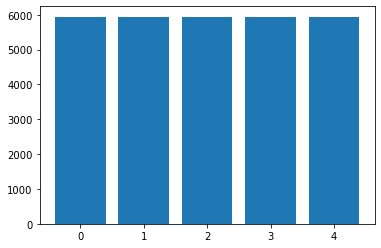

In [86]:
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

# Feature Selection

## Feature selection using ' feature importance' parameter of a simplified model 

In [180]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot

# define the model
model = RandomForestClassifier()

# fit the model
model.fit(X, y)


C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



RandomForestClassifier()

In [211]:
# get importance
importance = model.feature_importances_

# summarize feature importance
Columns = []
column_index =[]
selected_feature_importance = []

for i,v in enumerate(importance):
    if v > 0.005:
        print('Feature: %0d, Score: %.5f' % (i,v))
        Columns.append(X.columns[i])
        column_index.append(i)
        selected_feature_importance.append(v)

print("selected number of features: "+str(len(Columns)))

Feature: 0, Score: 0.00611
Feature: 1, Score: 0.00586
Feature: 2, Score: 0.00529
Feature: 3, Score: 0.00509
Feature: 4, Score: 0.00525
Feature: 5, Score: 0.00568
Feature: 6, Score: 0.00570
Feature: 7, Score: 0.00536
Feature: 512, Score: 0.00570
Feature: 514, Score: 0.00508
Feature: 517, Score: 0.00659
Feature: 519, Score: 0.00565
Feature: 521, Score: 0.00501
Feature: 523, Score: 0.00519
Feature: 524, Score: 0.00649
Feature: 525, Score: 0.00667
Feature: 527, Score: 0.00552
Feature: 528, Score: 0.00572
Feature: 532, Score: 0.03522
selected number of features: 19


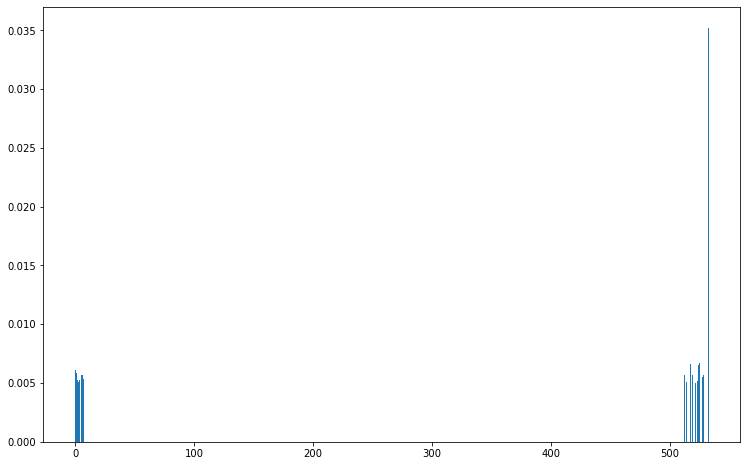

In [202]:
# plot feature importance

#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.bar([selected_feature[x] for x in range(len(selected_feature_importance))], selected_feature_importance)
plt.rcParams['figure.figsize'] = (12.5, 8.0)
pyplot.bar(column_index, selected_feature_importance)
pyplot.show()

In [212]:
X1=X[Columns]
X1.shape

(29725, 19)

## Feature selction using ElasticNet classifier

In [135]:
# import model
from sklearn.linear_model import ElasticNet
 

In [136]:
def elastic_net(X, y, alpha, models_to_plot={}):
    #Fit the model
    elasreg = ElasticNet(alpha=alpha,normalize=True, max_iter=1e5)
    elasreg.fit(X,y)
    y_pred = elasreg.predict(X)

    #Check if a plot is to be made for the entered alpha
    if alpha in models_to_plot:
        plt.subplot(models_to_plot[alpha])
        plt.tight_layout()
        plt.plot(X,y_pred)
        plt.plot(X,y,'.')
        plt.title('Plot for alpha: %.3g'%alpha)

    #Return the result in pre-defined format
    rss = sum((y_pred-y)**2)
    ret = [rss]
    ret.extend([elasreg.intercept_])
    ret.extend(elasreg.coef_)
    return ret

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other values of l1_ratio, no analytic formula is available.

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with d

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), ElasticNet())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to original_alpha * np.sqrt(n_samples) if l1_ratio is 1, and to original_alpha * n_samples if l1_ratio is 0. For other

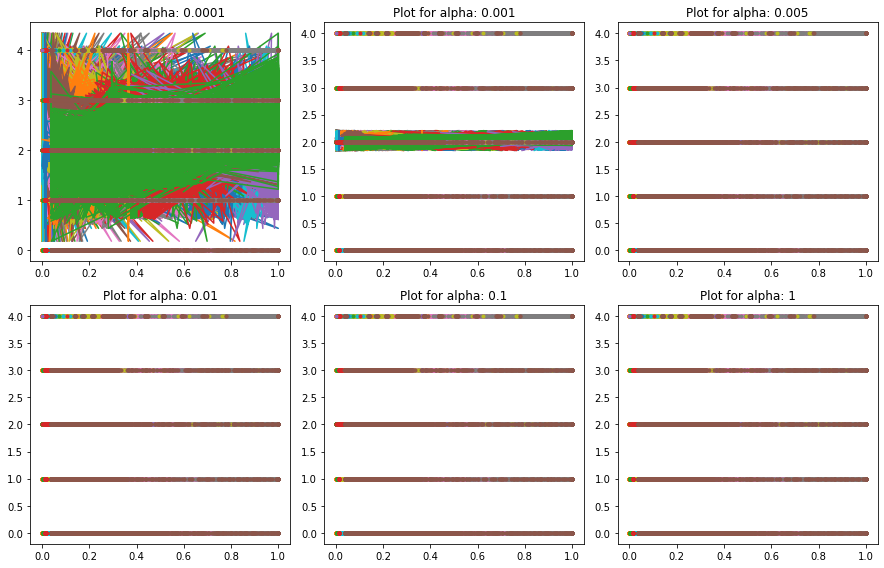

In [137]:
# Defining the alpha values to test
alpha_elastic = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,1e-1,1]

# Initializing the dataframe to store coefficients
col = ['rss','intercept'] + ['coef_x_%d'%i for i in range(len(X.columns))]
ind = ['alpha_%.2g'%alpha_elastic[i] for i in range(0,10)]
coef_matrix_elasnet = pd.DataFrame(index=ind, columns=col)

# Defining the models to plot
models_to_plot = {1e-4:231, 1e-3:232,5e-3:233, 1e-2:234, 1e-1:235, 1:236}

# Iterating over the 7 alpha values:
for i in range(10):
    coef_matrix_elasnet.iloc[i,] = elastic_net(X, y, alpha_elastic[i], models_to_plot);

In [140]:
# Train the model
elasreg3 = ElasticNet(alpha = .005)
elasreg3.fit(X,y)
 
# calculate the prediction and mean square error
y_pred1 = elasreg3.predict(X)#elasreg.predict(X_valid)
mean_squared_error1 = np.mean((y_pred1 - y)**2)
print("Mean Squared Error on validation set", mean_squared_error1)
 
elasreg_coeff3 = pd.DataFrame()
elasreg_coeff3["Columns"] = X.columns
elasreg_coeff3['Coefficient Estimate'] = pd.Series(abs(elasreg3.coef_))

C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



Mean Squared Error on validation set 1.6063140468419883


C:\Users\snk_n\anaconda3\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [163]:
elasreg3_coeff_final= elasreg_coeff3[elasreg_coeff3['Coefficient Estimate']>.15]
print("selected number of features: "+str(len(elasreg3_coeff_final)))
print("selected features and corresponding coefficients are: ")
elasreg3_coeff_final

selected number of features: 20
selected features and corresponding coefficients are: 


Columns  Coefficient Estimate
0                   0              0.374348
2                   2              0.301411
5                   5              0.604244
7                   7              0.331394
17                 17              0.251738
30                 30              0.196364
32                 32              0.591728
40                 40              0.268852
73                 73              0.356975
98                 98              0.260594
199               199              0.203782
203               203              0.180887
204               204              0.194301
208               208              0.318576
360               360              0.383186
513               513              0.435014
514               514              0.442935
516               516              0.409503
525               525              0.548438
532  Label_Confidence              1.730839

Text(0.5, 1.0, 'Feature importance using Elastic-net Model')

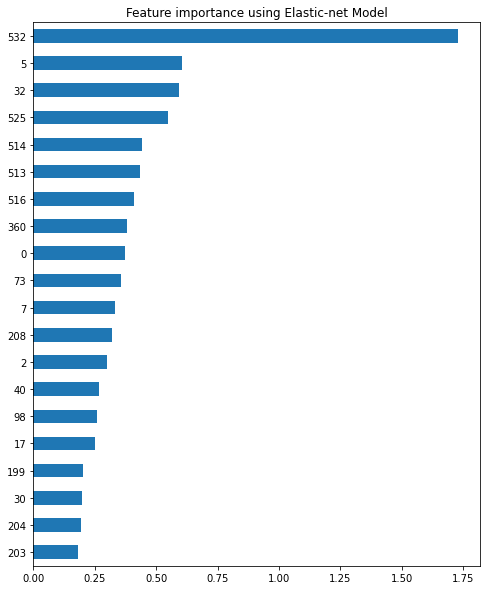

In [164]:
imp_coef = elasreg3_coeff_final['Coefficient Estimate'].sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Elastic-net Model")

In [170]:
X2=X.loc[:,elasreg3_coeff_final["Columns"]]
X2.shape

(29725, 20)

# Creating training and test data set

In [214]:
from sklearn.model_selection import train_test_split

## Creating first training and testing data-set using features identified by feature importance:

In [215]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y,test_size=.3, shuffle=True,random_state=42)

## Creating second training and testing data-set using features identified by ElasticNet:

In [216]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y,test_size=.3, shuffle=True,random_state=42)

# Model development

In [217]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
seed=101